# EDA for Kaggle competition CommonLit - Evaluate Student Summaries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import download

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from semantic_score import SemanticScore

### Import prompts

In [2]:
prompts_df = pd.read_csv(os.path.join('data', 'prompts_train.csv'))
prompts_df['prompt_text'] = prompts_df['prompt_text'].apply(lambda x: x.replace('\r\n', ' '))
prompts_df

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already ...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pla...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


#### What are average lengths of questions and source text?

In [3]:
length_prompt_texts = prompts_df['prompt_text'].apply(lambda x: len(x))
avg = np.mean(length_prompt_texts)
print(f'Average prompt text length = {avg} characters')
length_prompt_questions = prompts_df['prompt_question'].apply(lambda x: len(x))
avg = np.mean(length_prompt_questions)
print(f'Average prompt question length = {avg} characters')

Average prompt text length = 3845.25 characters
Average prompt question length = 117.5 characters


### Import student summaries

In [4]:
summaries_df = pd.read_csv(os.path.join('data', 'summaries_train.csv'))
summaries_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [5]:
summaries_df[['content', 'wording']].describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


### Score distributions

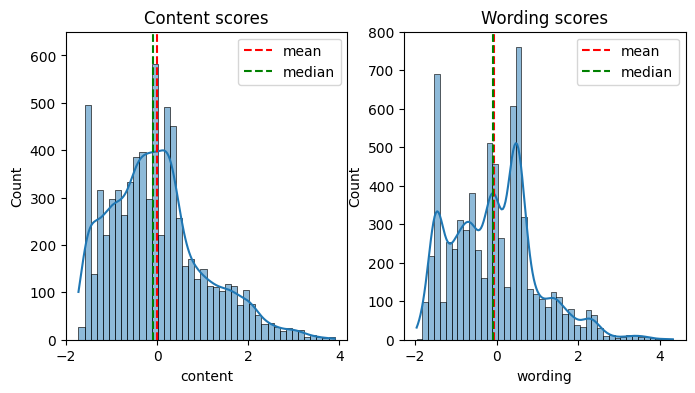

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sns.histplot(data=summaries_df, x='content', kde=True, ax=axes[0])
axes[0].set_title('Content scores')
axes[0].vlines(summaries_df['content'].mean(), ymin=0, ymax=700, label='mean', color='red', linestyles='dashed')
axes[0].vlines(summaries_df['content'].median(), ymin=0, ymax=700, label='median', color='green', linestyles='dashed')
axes[0].set_ylim(top=650)
axes[0].legend()

sns.histplot(data=summaries_df, x='wording', kde=True, ax=axes[1])
axes[1].vlines(summaries_df['wording'].mean(), ymin=0, ymax=900, label='mean', color='red', linestyles='dashed')
axes[1].vlines(summaries_df['wording'].median(), ymin=0, ymax=900, label='median', color='green', linestyles='dashed')
axes[1].set_ylim(top=800)
axes[1].set_title('Wording scores')
axes[1].legend()
plt.show()

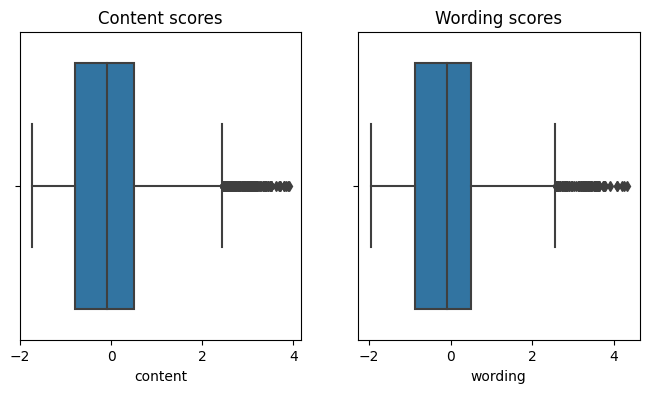

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sns.boxplot(data=summaries_df, x = 'content', ax=axes[0])
axes[0].set_title('Content scores')
sns.boxplot(data=summaries_df, x='wording', ax=axes[1])
axes[1].set_title('Wording scores')
plt.show()

### What proportions are outliers?

Outliers are values greater than (quantile_3rd + 1.5 * iqr)

In [8]:
quantiles = summaries_df[['content', 'wording']].quantile(q=[0.25, 0.75], axis=0)
content_iqr = quantiles.iloc[1, 0] - quantiles.iloc[0, 0]
content_threshold = quantiles.iloc[1, 0] + 1.5 * content_iqr
content_outliers = summaries_df[summaries_df['content'] > content_threshold][['student_id', 'content']]
content_outlier_ratio = content_outliers.shape[0] / summaries_df.shape[0]

wording_iqr = quantiles.iloc[1, 1] - quantiles.iloc[0, 1]
wording_threshold = quantiles.iloc[1, 1] + 1.5 * wording_iqr
wording_outliers = summaries_df[summaries_df['content'] > wording_threshold][['student_id', 'content']]
wording_outlier_ratio = wording_outliers.shape[0] / summaries_df.shape[0]

print(f'Content outliers: {content_outlier_ratio * 100: .2f}%')
print(f'Wording outliers: {wording_outlier_ratio * 100: .2f}%')

content_outlier_ids = set(content_outliers['student_id'].tolist())
wording_outlier_ids = set(wording_outliers['student_id'].tolist())
combined = content_outlier_ids.intersection(wording_outlier_ids)
both_ratio = len(combined) / summaries_df.shape[0]
print(f'Percent both scores outliers: {both_ratio * 100: .2f}%')

Content outliers:  2.37%
Wording outliers:  1.90%
Percent both scores outliers:  1.90%


### If we remove outlier scores?

In [9]:
summaries_cleaned_df = summaries_df[~summaries_df['student_id'].isin(combined)]
assert round(1 - summaries_cleaned_df.shape[0] / summaries_df.shape[0], 5) == round(both_ratio, 5)

Did not seem to be useful, but keep it here in case.

### Correlations between summary word counts and scores?

Only counting non-stop words

In [10]:

download('stopwords')
stop_words = stopwords.words('english')

def scale(x):
    mean = np.mean(x)
    std = np.std(x)
    x_scale = (x - mean) / std
    return x_scale

def count_words(text, vocab=False):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    if vocab:
        tokens = set(tokens)
    return len(tokens)

def count_sentences(text, word_count=False):
    sentences = sent_tokenize(text)
    if word_count:
        counts = [count_words(sentence) for sentence in sentences]
        return np.mean(counts)
    return len(sentences)

def objectivity(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_dict = sid.polarity_scores(text)
    return sentiment_dict['neu']

def fitline(x, y, deg):
    coef = np.polyfit(x, y, deg=deg)
    x_vals = np.linspace(np.min(x), np.max(x), num=x.shape[0])
    points = np.polyval(coef, x_vals)
    return x_vals, points

def plot_correlations(x, df, deg):
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    corr = np.corrcoef(x, df['content'])
    x_vals, trend = fitline(x, df['content'], deg=deg)

    sns.scatterplot(x=x, y=df['content'], ax=axes[0])
    axes[0].plot(x_vals, trend, color='red')
    axes[0].set_title(f'Correlation = {corr[0, 1]: .3f}')
    axes[0].set_ylabel('Content Score')

    corr = np.corrcoef(x, y=df['wording'])
    x_vals, trend = fitline(x, df['wording'], deg=deg)
    rmse = np.sqrt(mean_squared_error(df['wording'], trend))

    sns.scatterplot(x=x, y=df['wording'], ax=axes[1])
    axes[1].plot(x_vals, trend, color='red')
    axes[1].set_title(f'Correlation = {corr[0, 1]: .3f}')
    axes[1].set_ylabel('Wording Score')
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


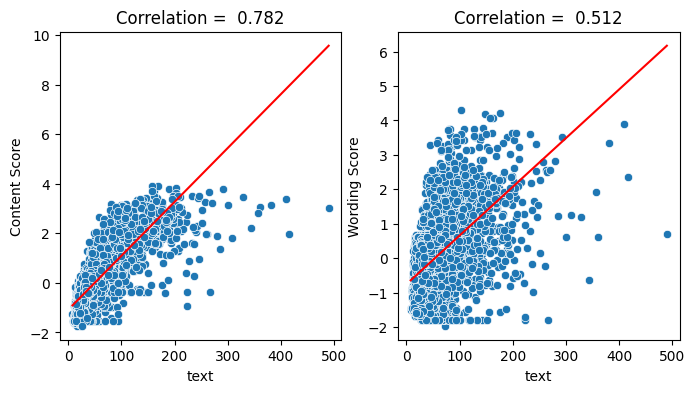

In [11]:
summary_lengths = summaries_df['text'].apply(count_words)
plot_correlations(summary_lengths, summaries_df, deg=1)

In [12]:
summaries_df['summary_length'] = summary_lengths

### Vocabulary size

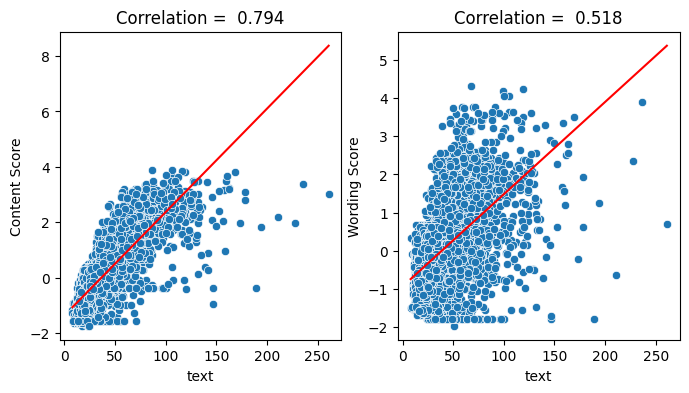

In [13]:
vocab_size = summaries_df['text'].apply(lambda x: count_words(x, vocab=True))
plot_correlations(vocab_size, summaries_df, deg=1)

In [14]:
np.corrcoef(summary_lengths, vocab_size)

array([[1.       , 0.9797052],
       [0.9797052, 1.       ]])

In [15]:
summaries_df['vocab_size'] = vocab_size

### Sentence counts

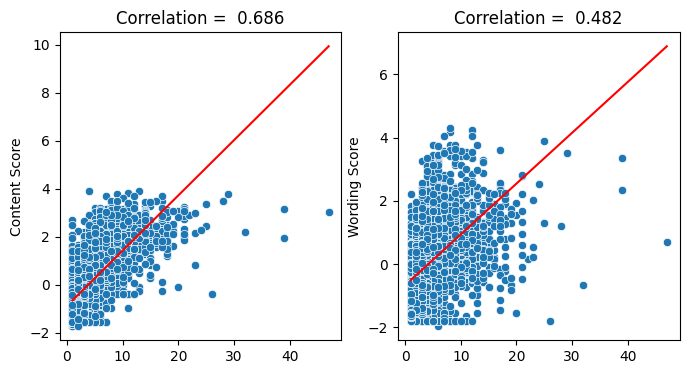

In [16]:
sentences_count = summaries_df['text'].apply(count_sentences).values
plot_correlations(sentences_count, summaries_df, deg=1)

In [17]:
np.corrcoef(vocab_size, sentences_count)

array([[1.        , 0.82235478],
       [0.82235478, 1.        ]])

In [18]:
summaries_df['sentences_count'] = sentences_count

### Average sentence wordcounts

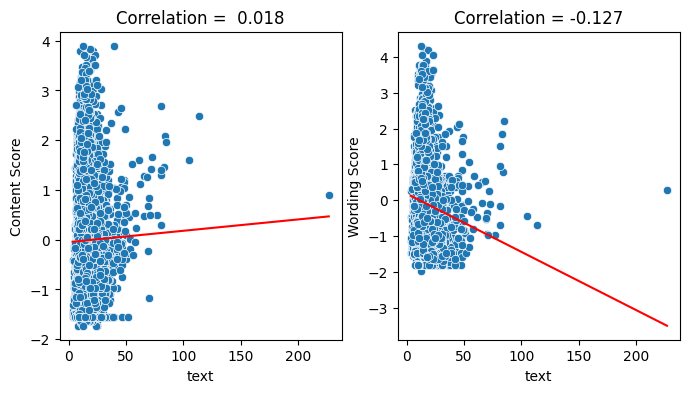

In [19]:
sentence_words = summaries_df['text'].apply(lambda x: count_sentences(x, word_count=True))
plot_correlations(sentence_words, summaries_df, deg=1)

In [20]:
np.corrcoef(vocab_size, sentence_words)

array([[1.        , 0.11567975],
       [0.11567975, 1.        ]])

In [21]:
summaries_df['sentence_words'] =  sentence_words

### Objectivity score

Which is proportion of neutral sentiment in each summary

In [22]:
objectivity_values = summaries_df['text'].apply(objectivity)

In [23]:
objectivity_values.describe()

count    7165.000000
mean        0.820065
std         0.134284
min         0.374000
25%         0.730000
50%         0.858000
75%         0.921000
max         1.000000
Name: text, dtype: float64

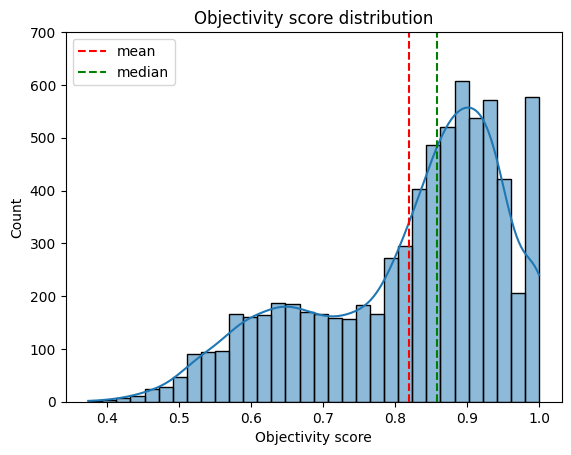

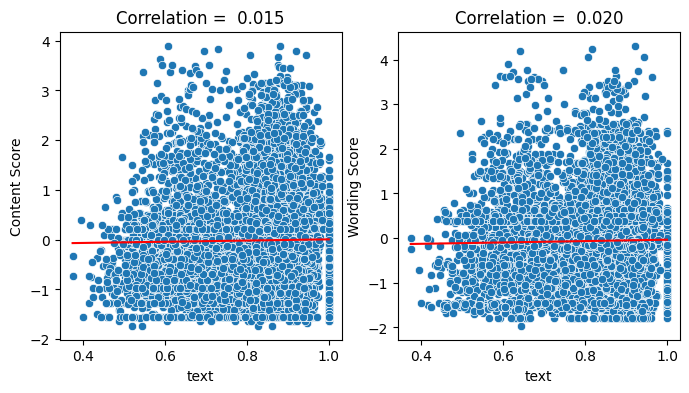

In [24]:
sns.histplot(x=objectivity_values, kde=True)
plt.vlines(objectivity_values.mean(), ymin=0, ymax=800, label='mean', color='red', linestyles='dashed')
plt.vlines(objectivity_values.median(), ymin=0, ymax=800, label='median', color='green', linestyles='dashed')
plt.title("Objectivity score distribution")
plt.xlabel("Objectivity score")
plt.legend()
plt.ylim(top=700)
plt.show()

plot_correlations(objectivity_values, summaries_df, deg=1)

In [25]:
summaries_df['objectivity'] = objectivity_values

### Merge data frames and export CSV file

In [26]:
merged_df = summaries_df.merge(prompts_df, on='prompt_id')
merged_df['prompt_text'] = merged_df['prompt_text'].apply(lambda x: x.replace('\r\n', ' '))
merged_df.rename(mapper={'text': 'summary_text'}, axis=1, inplace=True)
merged_df.drop(columns=['prompt_id'], inplace=True)
merged_df.head()

,student_id,summary_text,content,wording,summary_length,vocab_size,sentences_count,sentence_words,objectivity,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,The third wave was an experimentto see how peo...,0.205683,0.380538,43,36,4,10.750000,0.835,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pla...
1,0070c9e7af47,The Third Wave developed rapidly because the ...,3.272894,3.219757,151,101,14,10.785714,0.898,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pla...
2,0095993991fe,The third wave only started as an experiment w...,0.205683,0.380538,42,34,3,14.000000,1.000,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pla...
3,00c20c6ddd23,The experimen was orginally about how even whe...,0.567975,0.969062,51,40,3,17.000000,0.788,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pla...
4,00d40ad10dc9,The third wave developed so quickly due to the...,-0.910596,-0.081769,19,17,2,9.500000,1.000,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pla...


### Ratio of vocabulary of summaries and original texts

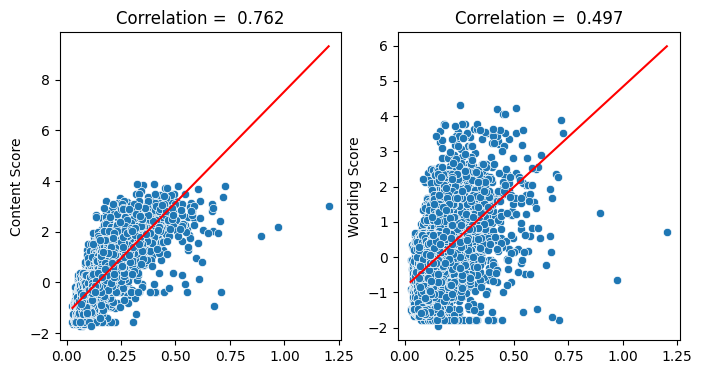

In [27]:
text_vocab_size = merged_df['prompt_text'].apply(lambda x: count_words(x, vocab=True))
vocab_ratios = vocab_size / text_vocab_size
plot_correlations(vocab_ratios, summaries_df, deg=1)

In [28]:
np.corrcoef(vocab_size, vocab_ratios)

array([[1.        , 0.95729257],
       [0.95729257, 1.        ]])

In [29]:
merged_df['vocab_ratios'] = vocab_ratios

In [30]:
scorer = SemanticScore()


In [31]:
scores = []
for i in range(merged_df.shape[0]):
    score = scorer.similarity(merged_df.iloc[i]["summary_text"], merged_df.iloc[i]['prompt_text'])
    scores.append(score)

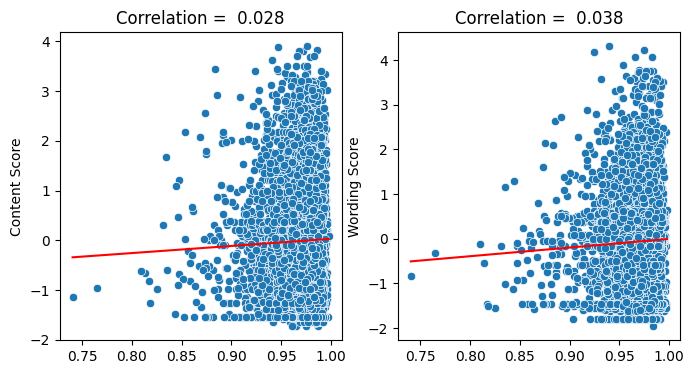

In [32]:
plot_correlations(np.array(scores), summaries_df, deg=1)

In [33]:
merged_df['semantic_scores'] = scores

In [34]:
merged_df.to_csv(os.path.join('data', 'merged_train.csv'), index=False)